In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 20.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Running on TPU  grpc://10.87.65.98:8470
Number of replicas: 8


In [5]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Responsible AI - Team #9 Folder/Data/preprocessed_data.csv')
df.head()

,text,label
0,"This is so cool. It's like, 'would you want yo...",not toxic
1,Thank you!! This would make my life a lot less...,not toxic
2,This is such an urgent design problem; kudos t...,not toxic
3,Is this something I'll be able to install on m...,not toxic
4,haha you guys are a bunch of losers.,toxic


In [7]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

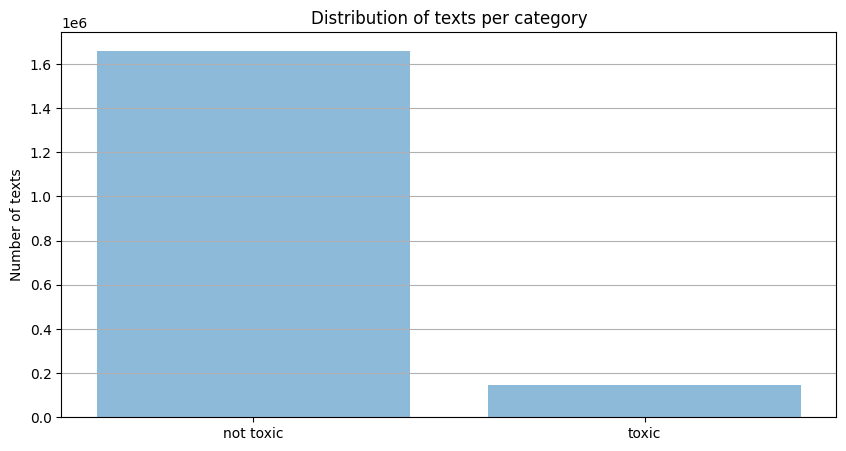

Counter({'not toxic': 1660540, 'toxic': 144334})


In [8]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [9]:
drop_percentage = 0.4

category = 'not toxic'
# Subset the DataFrame to include only rows with the specific category
category_df = df[df['label'] == category]

# Calculate the number of rows to drop based on the drop percentage
num_rows_to_drop = int(drop_percentage * len(category_df))

# Randomly sample rows to drop and store the remaining rows in a new DataFrame
remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

# Subset the original DataFrame to exclude rows with the specific category and concatenate it with the remaining rows
df = pd.concat([df[df['label'] != category], remaining_rows])

In [10]:
'''drop_percentage = 0.95

category = 'toxic'
# Subset the DataFrame to include only rows with the specific category
category_df = df[df['label'] == category]

# Calculate the number of rows to drop based on the drop percentage
num_rows_to_drop = int(drop_percentage * len(category_df))

# Randomly sample rows to drop and store the remaining rows in a new DataFrame
remaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)

# Subset the original DataFrame to exclude rows with the specific category and concatenate it with the remaining rows
df = pd.concat([df[df['label'] != category], remaining_rows])'''

"drop_percentage = 0.95\n\ncategory = 'toxic'\n# Subset the DataFrame to include only rows with the specific category\ncategory_df = df[df['label'] == category]\n\n# Calculate the number of rows to drop based on the drop percentage\nnum_rows_to_drop = int(drop_percentage * len(category_df))\n\n# Randomly sample rows to drop and store the remaining rows in a new DataFrame\nremaining_rows = category_df.sample(n=len(category_df)-num_rows_to_drop, random_state=42)\n\n# Subset the original DataFrame to exclude rows with the specific category and concatenate it with the remaining rows\ndf = pd.concat([df[df['label'] != category], remaining_rows])"

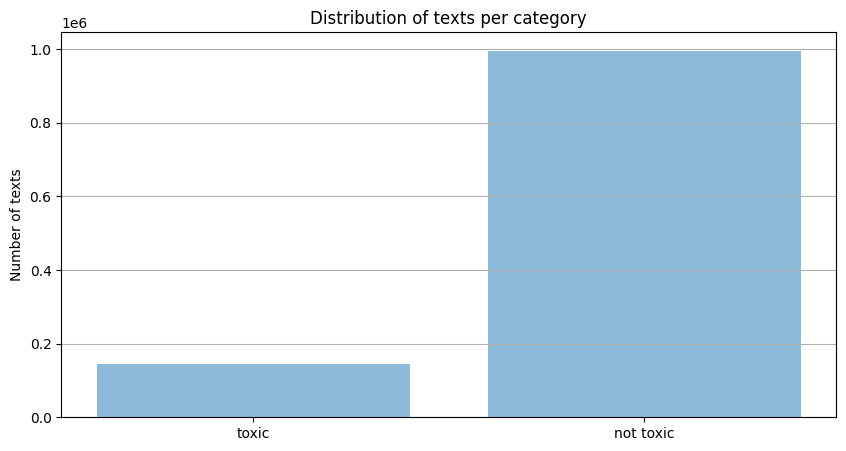

Counter({'not toxic': 996324, 'toxic': 144334})


In [11]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [12]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

In [13]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 1140658
Number of categories: 2
Done!


In [14]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [15]:
# Transform categories into numbers
category_to_id = {'toxic': 1, 'not toxic': 0}
category_to_name = {1: 'toxic', 0: 'not toxic'}

for index, c in enumerate(y_data):
    category_id = category_to_id[c]
    y_data[index] = category_id

In [16]:
#y_data = y_data.astype(int)
#y_data = np.eye(2)[y_data]

y_data = np.asarray(y_data, dtype='int32')
#y_test = np.asarray(y_test, dtype='int32')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=35) # random_state to reproduce results

In [18]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [19]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

In [20]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.AdamW(lr=1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model

In [21]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [22]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3


16041/16041 [==============================] - 2811s 170ms/step - loss: 0.4403 - accuracy: 0.8731 - val_loss: 0.3769 - val_accuracy: 0.8750
Epoch 2/3
16041/16041 [==============================] - 2654s 165ms/step - loss: 0.3801 - accuracy: 0.8733 - val_loss: 0.3769 - val_accuracy: 0.8750
Epoch 3/3
16041/16041 [==============================] - 2659s 166ms/step - loss: 0.3801 - accuracy: 0.8733 - val_loss: 0.3769 - val_accuracy: 0.8750


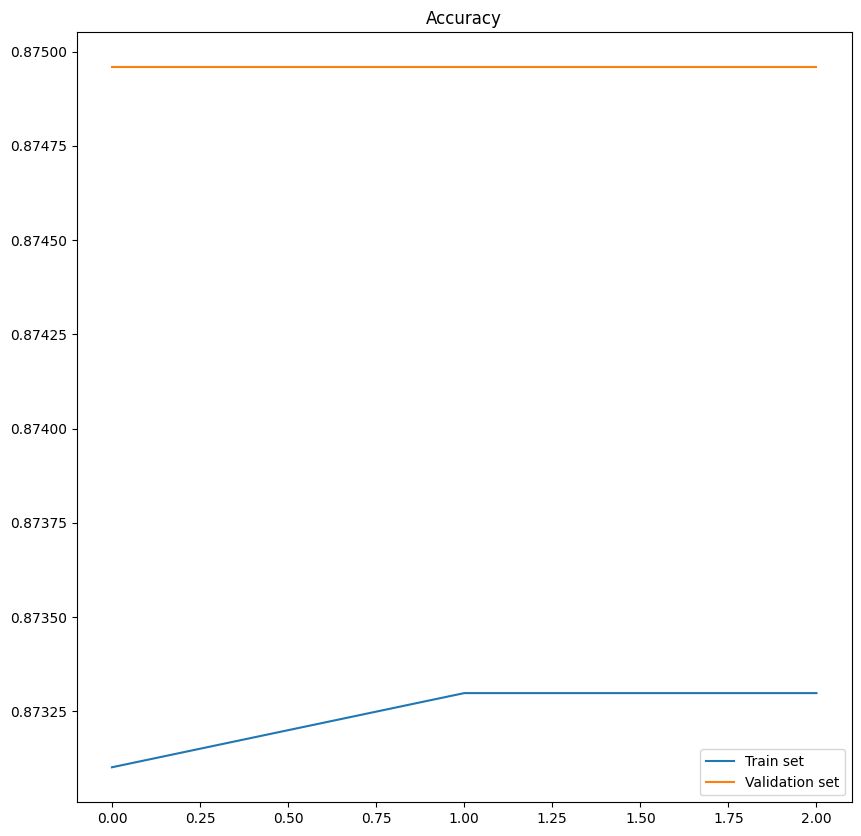

In [23]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [24]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 87.50%


In [27]:
model.save('/content/drive/MyDrive/Responsible AI - Team #9 Folder/trained_model.h5')